In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from scipy.optimize import newton

#module_path = os.path.abspath(os.path.join('../../..'))

#if module_path not in sys.path :
#    sys.path.append(module_path)
#import _ressources.flux as fl


from matplotlib.colors import LogNorm, SymLogNorm

In [2]:
def Lambda(chis, chiv) :
    c1, s1 = np.cosh(1./chis), np.sinh(1./chis)
    if chis == chiv :
        return np.cosh(0.5/chiv) * (1 - chiv*s1) / (2*chiv*s1) 
    return chis*(chis*s1*np.cosh(0.5/chiv) - chiv*(1.+c1)*np.sinh(0.5/chiv)) / (s1 * (chiv**2 - chis**2))

def zero_Jv_DelP(DelC, chis, chiv) :
    return -DelC*Lambda(chis, chiv) /np.cosh(0.5/chiv)

def Jv(DelP, DelC, chis, chiv) :
    return chiv*(DelP*np.cosh(0.5/chiv)/np.sinh(0.5/chiv) + DelC*Lambda(chis, chiv) /np.sinh(0.5/chiv))

def asymmetric_curve(Xs, Xv, dC_max = 5., nb_pts=101) :
    # RIGHT PART
    dC2_right = np.linspace(1, dC_max, nb_pts)
    dC1_right = 1
    DelC_right = dC2_right - dC1_right

    P1_right = 1

    DelP_right = zero_Jv_DelP(DelC_right, Xs, Xv)
    
    P2_right = DelP_right + P1_right
    
    Asym_dC_right = (dC2_right-dC1_right)/(dC2_right+dC1_right)
    Asym_dP_right = (P2_right-P1_right)/(P2_right+P1_right)
    
    # LEFT PART
    dC1_left = np.linspace(1, dC_max, nb_pts)
    dC2_left = 1
    DelC_left = dC2_left - dC1_left

    P2_left = 1

    DelP_left = zero_Jv_DelP(DelC_left, Xs, Xv)
    
    P1_left = P2_left - DelP_left

    Asym_dC_left = (dC2_left-dC1_left)/(dC2_left+dC1_left)
    Asym_dP_left = (P2_left-P1_left)/(P2_left+P1_left)
    
    # CONCATENATE
    Asym_dC = np.concatenate((Asym_dC_left[::-1], Asym_dC_right))
    Asym_dP = np.concatenate((Asym_dP_left[::-1], Asym_dP_right))
    return Asym_dC, Asym_dP

c_list = ['#037bfc', '#1403fc', '#2580c2', 
          '#ff4800', '#c71e1e', '#ff7c1f',
          '#00bf03', '#24bd54', '#5dba16']
lst = ['-', '-', '-', '.']

# Panel A

<ipython-input-3-5da3a419787c>:40: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=SymLogNorm(linthresh=1e-1, linscale=1, vmin=-1e3, vmax=1e3),
<ipython-input-3-5da3a419787c>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax.pcolormesh(dp_mesh, dc_mesh, jv_tot,


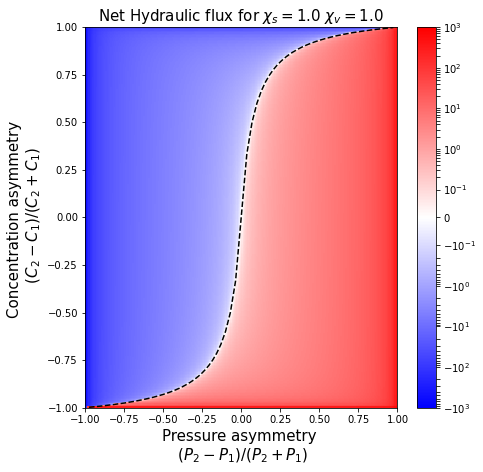

In [3]:
chis = 1.
chiv = 1.

npts_p, npts_c = 256, 256
dpmin, dpmax = -0.999, 0.999
dcmin, dcmax = -0.999, 0.999
DP_list = np.linspace(dpmin, dpmax, npts_p)
DC_list = np.linspace(dcmin, dcmax, npts_c)

dp_mesh, dc_mesh = np.meshgrid(DC_list, DP_list)

jv_tot = np.zeros((npts_p, npts_c))

for i in range(npts_p) :
    for j in range(npts_c) :
        dc = dc_mesh[i, j]
        dp = dp_mesh[i, j]
        
        if dp > 0. :
            P1 = 1.
            P2 = P1*(1.+dp)/(1.-dp)
        else :
            P2 = 1.
            P1 = P2*(1.-dp)/(1.+dp)
            
        if dc > 0. :
            C1 = 1.
            C2 = C1*(1.+dc)/(1.-dc)
        else :
            C2 = 1.
            C1 = C2*(1.-dc)/(1.+dc)
            
        jv_tot[i, j] = Jv(DelP=P2-P1, DelC=C2-C1, chis=chis, chiv=chiv)
        
# Curve
Asym_dC, Asym_dP = asymmetric_curve(Xs=chis, Xv=chiv, dC_max=1000., nb_pts=1001)    
    
fig, ax = plt.subplots(figsize=(7, 7))
pcm = ax.pcolormesh(dp_mesh, dc_mesh, jv_tot,
                       norm=SymLogNorm(linthresh=1e-1, linscale=1, vmin=-1e3, vmax=1e3),
                    cmap='bwr', rasterized=False)

ax.plot(np.copy(Asym_dP), np.copy(Asym_dC), label = r'$\chi_v=$' +str(1.), color='k', linestyle='--')

ax.set_title(r'Net Hydraulic flux for $\chi_s = $'+str(chis)+r' $\chi_v = $'+str(chiv), fontsize=15)
fig.colorbar(pcm, ax=ax)
ax.set_ylabel('Concentration asymmetry \n '+r'$(C_2-C_1)/(C_2+C_1)$', fontsize=15)
ax.set_xlabel('Pressure asymmetry \n '+r'$(P_2-P_1)/(P_2+P_1)$', fontsize=15)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
#plt.grid()
plt.savefig('figure2_panelA.eps', format='eps')
plt.show()

Diagram of the net flow $\bar{J}_{2\rightarrow 1}$ as a function of concentration and pressure asymettries, for $\chi_{s,v}=1$.

# Panel B

In [4]:
def calc_deltaC(chiv_list, P1, P2, C1, chis) :
    
    DP = P2-P1
    Pbar = P1+P2
    #print(DP/Pbar)

    delC = -np.array([DP*np.cosh(.5/chiv_list[i])/Lambda(chis, chiv_list[i]) for i in range(len(chiv_list))])
    C2 = C1 + delC
    delta_C = (C2-C1)/(C2+C1)
    return delta_C

<ipython-input-5-080fab23a361>:26: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=SymLogNorm(linthresh=1e-1, linscale=1, vmin=-1e3, vmax=1e3),
<ipython-input-5-080fab23a361>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax.pcolormesh(chi_mesh, Delta_C_mesh, jv_array,


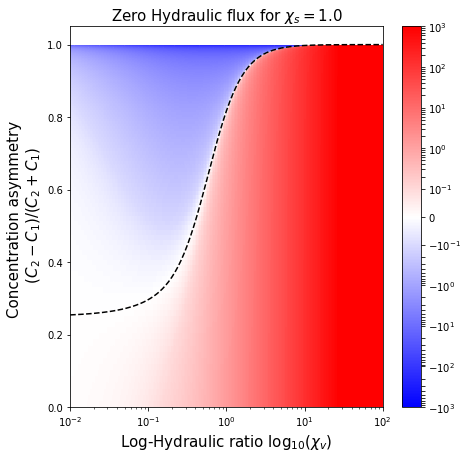

In [5]:


C1 = 1.
P1, P2 = 1., 5./3.

npts_c = 201
npts_chi = 201

chiv_list = np.logspace(-2, 2, npts_chi)
#C2_list = np.linspace(0., 1000, npts_c)
C2_list = np.logspace(0, 3, npts_c)
C2_mesh, chi_mesh = np.meshgrid(C2_list, chiv_list)

Delta_C_mesh = (C2_mesh - C1) / (C2_mesh + C1)

jv_array = np.zeros((npts_chi, npts_c))
for i in range(npts_chi) :
    for j in range(npts_c) :
        jv_array[i, j] = Jv(DelP=P2-P1, DelC=C2_mesh[i, j]-C1, chis=1, chiv=chi_mesh[i, j])

delta_C = calc_deltaC(chiv_list, P1, P2, C1, chis)        
        
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title(r'Zero Hydraulic flux for $\chi_s = $'+str(chis), fontsize=15)

pcm = ax.pcolormesh(chi_mesh, Delta_C_mesh, jv_array,
                       norm=SymLogNorm(linthresh=1e-1, linscale=1, vmin=-1e3, vmax=1e3),
                    cmap='bwr', rasterized=False)

ax.set_xscale('log')

# First curve
plt.plot(chiv_list, delta_C, label = r'$\Delta_p = $'+"{:2.2f}".format((P2-P1)/(P1+P2)), color='k', linestyle='--')

fig.colorbar(pcm, ax=ax)

ax.set_ylabel('Concentration asymmetry \n '+r'$(C_2-C_1)/(C_2+C_1)$', fontsize=15)
ax.set_xlabel(r'Log-Hydraulic ratio $\log_{10}(\chi_v)$', fontsize=15)
#ax.grid()
plt.savefig('figure2_panelB.eps', format='eps', dpi=100)
plt.show()



Diagram of the net flow $\bar{J}_{2\rightarrow 1}$ as a function of concentration asymmetry and pressure screening parameter $\chi_v$, for $\chi_{s}=1$ and $\Delta_P = 0.25$.

# Panel C

In [3]:
d = {}
# tau_v = 1
# d[taus][chiv][chis]
taus = 100
d[taus] = {}


for chiv in [10] :
    d[taus][chiv] = {}
    for chis in [0.01, 1, 100] :
        path = os.path.join('taus'+str(taus)+'_chiv'+str(chiv)+'_chis'+str(chis), 'distrib_length.dat')
        d[taus][chiv][chis] = np.genfromtxt(path, skip_footer=2)
    
taus, chiv, chis = 1, 10, 1
d[taus] = {}
d[taus][chiv] = {}
path = os.path.join('taus'+str(taus)+'_chiv'+str(chiv)+'_chis'+str(chis), 'distrib_length.dat')
d[taus][chiv][chis] = np.genfromtxt(path, skip_footer=2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


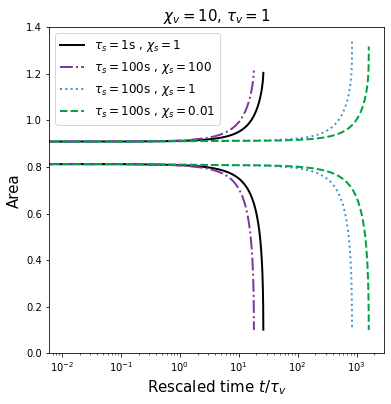

In [5]:
tauv = 1
chiv = 10

plt.figure(figsize=(6, 6))
plt.xscale('log')

chis, taus = 1, 1
plt.plot(d[taus][chiv][chis][:, 0], d[taus][chiv][chis][:, 1], linestyle='-', color='k', linewidth=2, label = r'$\tau_s='+str(taus)+'$' + r's , $\chi_s = '+str(chis) + '$')
plt.plot(d[taus][chiv][chis][:, 0], d[taus][chiv][chis][:, 2], linestyle='-', color='k', linewidth=2, )

chis, taus = 100, 100
plt.plot(d[taus][chiv][chis][:, 0], d[taus][chiv][chis][:, 1], linestyle='-.', color='#83359F', linewidth=2, label = r'$\tau_s='+str(taus)+'$' + r's , $\chi_s = '+str(chis) + '$')
plt.plot(d[taus][chiv][chis][:, 0], d[taus][chiv][chis][:, 2], linestyle='-.', color='#83359F', linewidth=2, )

chis, taus = 1, 100
plt.plot(d[taus][chiv][chis][:, 0], d[taus][chiv][chis][:, 1], linestyle='dotted', color='#4394D6', linewidth=2, label = r'$\tau_s='+str(taus)+'$' + r's , $\chi_s = '+str(chis) + '$')
plt.plot(d[taus][chiv][chis][:, 0], d[taus][chiv][chis][:, 2], linestyle='dotted', color='#4394D6', linewidth=2, )

chis, taus = 0.01, 100
plt.plot(d[taus][chiv][chis][:, 0], d[taus][chiv][chis][:, 1], linestyle='--', color='#00A343', linewidth=2, label = r'$\tau_s='+str(taus)+'$' + r's , $\chi_s = '+str(chis) + '$')
plt.plot(d[taus][chiv][chis][:, 0], d[taus][chiv][chis][:, 2], linestyle='--', color='#00A343', linewidth=2, )

plt.ylim(0., 1.4)
plt.title(r'$\chi_v=10$, $\tau_v=1$', fontsize=15)
plt.legend(fontsize=12)
plt.xlabel(r'Rescaled time $t/\tau_v$', fontsize=15)
plt.ylabel('Area', fontsize=15)
plt.savefig('figure2_panelC.eps', format='eps')

plt.show()


Time evolution of the area of two lumens as function of $\tau_s$ and $\chi_s$. Other simulation parameters are $\chi_v = 10$, $\chi_v = 1s$.